In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
from timeit import default_timer as timer
import heapq

import warnings
warnings.filterwarnings("ignore")

## Project 2a

In [2]:
# project 2a
# first we use adjacency matrix, generate adj matrix
def generateAdjMatrix(networkxG, x):
    temp = nx.adjacency_matrix(networkxG)
#     print(temp)
    tempC = temp.tocoo()
    size = temp.shape[0]
    adjMatrix = [[0 for j in range(size)] for i in range(size)]
    for i in range(len(tempC.data)):
        row, col = tempC.row[i], tempC.col[i]
        randomWeight = random.randint(1,x)
        adjMatrix[row][col] = randomWeight
    return adjMatrix 

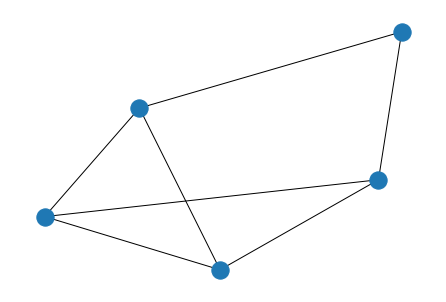

In [24]:
# number of nodes, number of edges, seed, directed=False
G_temp = nx.gnm_random_graph(5, 7, 10, False)
G = G_temp
nx.draw(G)

In [25]:
adj_matrix = generateAdjMatrix(G, 10)
print(adj_matrix)

[[0, 10, 6, 0, 1], [6, 0, 1, 3, 0], [6, 6, 0, 6, 0], [0, 4, 5, 0, 1], [9, 0, 0, 10, 0]]


### Implementation

In [27]:
class Graph:
    def __init__(self, V, adjMatrix) -> None:
        self.size = V
        self.adjMatrix = adjMatrix
        
    def addWeightedEdge(self, v1, v2, weight=1):
        if (0 <= v1 < self.size and 0 <= v2 < self.size):
            self.adjMatrix[v1][v2] = weight
            print(f"vertex {v1} connected to vertex {v2} with weight {weight}")
            return
        print("Unsucessful")

class PqElement:
    def __init__(self, distanceFromSource, node) -> None:
        self.node = node
        self.distanceFromSource = distanceFromSource
        
    def __lt__(self, other):
        return self.distanceFromSource < other.distanceFromSource

    def __repr__(self):
        return f'node: {self.node}, distanceFromSource: {self.distanceFromSource}'

class PriorityQueueArray:
    def __init__(self) -> None:
        self.pq = []
    
    def __str__(self):
        return ' '.join([str(i) for i in self.pq])
    
    # distance from source == weight
    def enqueue(self, data):
        self.pq.append(data)
    
    def isEmpty(self):
        return len(self.pq) == 0
    
    # pop and get min
    def delete(self): #O(n)
        try:
            minVal = 0
            for i in range(len(self.pq)):
                if self.pq[i].distanceFromSource < self.pq[minVal].distanceFromSource:
                    minVal = i
            item = self.pq[minVal]
            del self.pq[minVal]
            return item
        except IndexError:
            print("Error")
        
    
def dijkstra(graph: Graph, source: int):
    d = [float("inf") for i in range(graph.size)]
    pi = [None for i in range(graph.size)]
    S = [0 for i in range(graph.size)]
    
    if (not (0 <= source < graph.size)):
        print("err")
        return
    
    d[source] = 0
    
    Q = PriorityQueueArray()
    for v in range(graph.size):
        toInsert = PqElement(d[v], v)
        Q.enqueue(toInsert)

    while (not Q.isEmpty()):
        cheapest = Q.delete()
        u = cheapest.node
        S[u] = 1
        for v in range(len(graph.adjMatrix)):
            if (graph.adjMatrix[u][v] and S[v] != 1 and d[v] > d[u] + graph.adjMatrix[u][v]):
                for i in range(len(Q.pq)):
                    if (Q.pq[i].node == v):
                        del Q.pq[i]
                        break
                d[v] = d[u] + graph.adjMatrix[u][v]
                pi[v] = u
                
                # insert v into Q according to its d[v]
                toInsert = PqElement(d[v], v)
                Q.enqueue(toInsert)
    
    return d, pi, S

Fix V change density of the graph, density - d = e/(v(v-1))  (total edges/edges of complete graph). note that this is a directed graph, so in reality there are 2 * E edges

V - number of nodes
total_nodes_explored - how many source nodes to consider

In [29]:
project2a =[]

V = 500
# E = how many  edges? 0 <= E <= V(V-1), connected V-1 <= E <= V(V-1)

for density in np.arange(0.1, 1.1, 0.1):
    # number of nodes, number of edges, seed, directed=False
    timeTaken = 0
    density = float(density)
    print(density)
    # pick source node from 0 - 30
    total_nodes_explored = 10
    for source_node in range(0, total_nodes_explored):
        E = int(density * (V) * (V-1))
        G_temp = nx.gnm_random_graph(V, E, 10, False)
        adj_matrix = generateAdjMatrix(G_temp, V) # graph, maximum weight (1-V)
        generatedGraph = Graph(V, adj_matrix)
        start = timer()
        d, pi, S = dijkstra(generatedGraph, source_node)
        timeTaken += (timer() - start)*1000 # in ms
    project2a.append([V, E, density, timeTaken/total_nodes_explored])

0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7000000000000001
0.8
0.9
1.0


In [30]:
project2a

[[500, 24950, 0.1, 131.341282899848],
 [500, 49900, 0.2, 146.7461837000883],
 [500, 74850, 0.30000000000000004, 158.51008449990331],
 [500, 99800, 0.4, 166.1392321006133],
 [500, 124750, 0.5, 169.59111879987177],
 [500, 149700, 0.6, 169.31590990006953],
 [500, 174650, 0.7000000000000001, 170.2034455998728],
 [500, 199600, 0.8, 170.3317399997104],
 [500, 224550, 0.9, 172.383441900638],
 [500, 249500, 1.0, 171.32547329965746]]

## Project 2b, using adjacency list and heap

In [31]:
def generateAdjList(networkxG, x):
    temp = nx.adjacency_matrix(networkxG)
#     print(temp)
    tempC = temp.tocoo()
    size = temp.shape[0]
    adjList = [[] for i in range(size)]
    for i in range(len(tempC.data)):
        row, col = tempC.row[i], tempC.col[i] 
        randomWeight = random.randint(1,x)
        adjList[row].append((col, randomWeight))
    return adjList

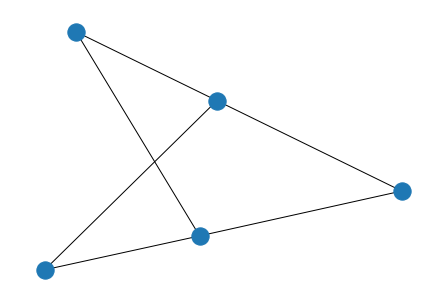

In [32]:
# number of nodes, number of edges, seed, directed=False
G_temp = nx.gnm_random_graph(5, 6, 10, False)
G = G_temp
nx.draw(G)

In [10]:
adj_list = generateAdjList(G, 10)
print(adj_list)

[[(1, 4), (2, 2), (4, 10)], [(0, 3), (3, 7)], [(0, 9), (3, 3)], [(1, 3), (2, 4), (4, 4)], [(0, 6), (3, 1)]]


### Implementation

In [33]:
class Graph:
    def __init__(self, V, adjList=[]) -> None:
        self.size = V
        if (adjList == []):
            self.adjList = [[] for i in range(V)]
        else:
            self.adjList = adjList
        
    def addWeightedEdge(self, v1, v2, weight=1):
        if (0 <= v1 < self.size and 0 <= v2 < self.size):
            self.adjList[v1].append((v2, weight))
            print(f"vertex {v1} connected to vertex {v2} with weight {weight}")
            return
        print("Unsucessful")

class PqElement:
    def __init__(self, distanceFromSource, node) -> None:
        self.node = node
        self.distanceFromSource = distanceFromSource
        
    def __lt__(self, other):
        return self.distanceFromSource < other.distanceFromSource

    def __repr__(self):
        return f'node: {self.node}, distanceFromSource: {self.distanceFromSource}'
    
def dijkstra(graph: Graph, source: int):
    d = [float("inf") for i in range(graph.size)]
    pi = [None for i in range(graph.size)]
    S = [0 for i in range(graph.size)]
    
    if (not (0 <= source < graph.size)):
        print("err")
        return
    
    d[source] = 0
    
    Q = []
    for v in range(graph.size):
        toInsert = PqElement(d[v], v)
        heapq.heappush(Q, toInsert)
    
    while (len(Q)):
        cheapest = heapq.heappop(Q) # O(logn)
        u = cheapest.node
        S[u] = 1
        for i in range(len(graph.adjList[u])):
            v, weight = graph.adjList[u][i]
            if (S[v] != 1 and d[v] > d[u] + weight):
                for elem in Q:
                    if (elem.node == v):
                        Q.remove(elem)
                        break
                d[v] = d[u] + weight
                pi[v] = u
                
                # insert v into Q according to its d[v]
                toInsert = PqElement(d[v], v)
                heapq.heappush(Q, toInsert)
    
    return d, pi, S  

In [34]:
project2b =[]

V = 500
# E = how many edges? 0 <= E <= V(V-1), connected V-1 <= E <= V(V-1)

for density in np.arange(0.1, 1.1, 0.1):
    # number of nodes, number of edges, seed, directed=False
    timeTaken = 0
    density = float(density)
    print(density)
    # pick source node from 0 - 30
    for source_node in range(0, 10):
        E = int(density * (V) * (V-1))
        G_temp = nx.gnm_random_graph(V, E, 10, False)
        adj_list = generateAdjList(G_temp, V) # graph, maximum weight (1-V)
        generatedGraph = Graph(V, adj_list)
        start = timer()
        d, pi, S = dijkstra(generatedGraph, source_node)
        timeTaken += (timer() - start)*1000 # in ms
    project2b.append([V, E, density, timeTaken/30])

0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7000000000000001
0.8
0.9
1.0


In [35]:
project2b

[[500, 24950, 0.1, 95.60993853338005],
 [500, 49900, 0.2, 89.54294236670346],
 [500, 74850, 0.30000000000000004, 91.39484246661596],
 [500, 99800, 0.4, 87.61234543338408],
 [500, 124750, 0.5, 76.06695286655547],
 [500, 149700, 0.6, 76.24995539990778],
 [500, 174650, 0.7000000000000001, 76.08508389997344],
 [500, 199600, 0.8, 76.27316146675487],
 [500, 224550, 0.9, 76.38408816668137],
 [500, 249500, 1.0, 76.88651689998854]]